In [ ]:
import os
import math
import random
import shutil
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
mnist = keras.datasets.mnist

(X_train,Y_train),(X_test,Y_test) = mnist.load_data()

In [ ]:
X_train,X_test = X_train/255.0,X_test/255.0

In [ ]:
inputs1 = tf.keras.Input(shape=(28,28))
reshape1 = layers.Reshape((28,28,1),input_shape = (28,28))
conv1 = layers.Conv2D(2,kernel_size=(2,2),activation='tanh')
conv2 = layers.Conv2D(1,kernel_size=(2,2),activation='tanh')
maxPool = layers.MaxPool2D((2,2))
flatten1 = layers.Flatten()
dense1 = layers.Dense(40,activation='tanh')
dense2 = layers.Dense(10,activation='sigmoid')
dense3 = layers.Dense(49,activation='sigmoid')
dense4 = layers.Dense(250,activation='sigmoid')
#reshape2 = tf.keras.layers.Reshape((7, 7,1), input_shape=(7*7,))
#CTranspose = layers.Convolution2DTranspose(1,(4,4),activation='sigmoid')
#flatten2 = layers.Flatten()
dense5 = layers.Dense(28*28,activation='sigmoid')
main_output = tf.keras.layers.Reshape((28, 28,1), input_shape=(28*28,))

In [ ]:
x1 = reshape1(inputs1)
x1 = conv1(x1)
x1 = conv2(x1)
x1 = maxPool(x1)
x1 = flatten1(x1)
x1 = dense1(x1)
x1 = dense2(x1)
outputs2 = x1

encoder = keras.Model(inputs=inputs1,outputs = outputs2,name = 'Encoder')


inputs2 = keras.Input(shape=(10))
x2 = dense3(inputs2)
#x2 = reshape2(x2)
#x2 = CTranspose(x2)
#x2 = flatten2(x2)
x2 = dense4(x2)
x2 = dense5(x2)
outputs1 = main_output(x2)

decoder = keras.Model(inputs=inputs2,outputs = outputs1,name = 'Decoder')

AutoEncoder = keras.Model(inputs=inputs1,outputs = decoder(encoder(inputs1)),name = 'AutoEncoder')

print(encoder.summary())
print('')
print('')
print(decoder.summary())
print('')
print('')
print(AutoEncoder.summary())

Model: "Encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 2)         10        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 1)         9         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 169)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 40)                6800

In [ ]:
loss = keras.losses.mean_squared_error
optimizer = keras.optimizers.Adam(learning_rate=0.007)
metrics = ['accuracy']

AutoEncoder.compile(loss=loss,metrics=metrics,optimizer=optimizer)

In [ ]:
batch_size = 32
epochs = 4

AutoEncoder.fit(x = X_train,y = X_train,batch_size=batch_size,epochs=epochs,verbose=1)

Epoch 1/4
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0430 - accuracy: 0.8001
Epoch 2/4
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0266 - accuracy: 0.8064
Epoch 3/4
1875/1875 [==============================] - 25s 14ms/step - loss: 0.0229 - accuracy: 0.8083
Epoch 4/4
1875/1875 [==============================] - 26s 14ms/step - loss: 0.0206 - accuracy: 0.8093


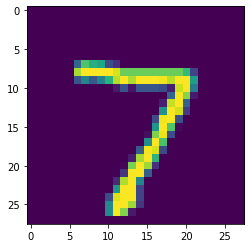

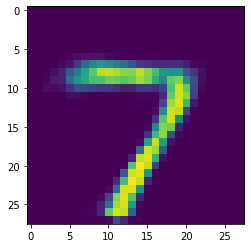

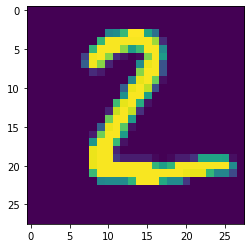

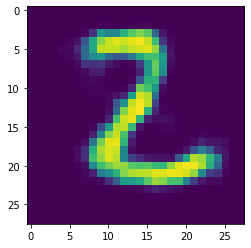

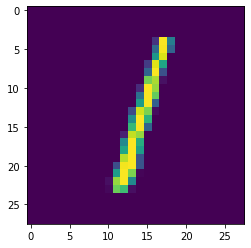

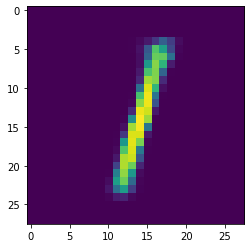

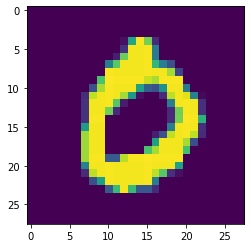

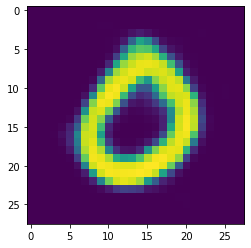

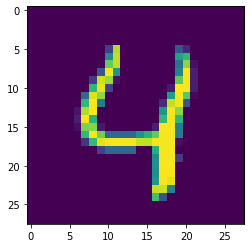

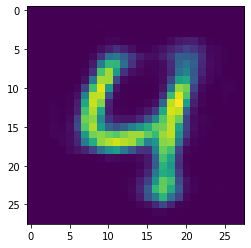

In [ ]:
res = AutoEncoder.predict(X_test[0:5])

for i in range(5):
  plt.imshow(X_test[i])
  plt.show()
  plt.imshow(np.reshape(res[i],(28,28)))
  plt.show()

In [ ]:
class Knn:
  def __init__(self,_num_classes = 10,_K = 1):
    self.num_classes = _num_classes
    self.K = _K
    self.Data = []
  
  def fit(self,X_super,y_super):
    for idx,_ in enumerate(X_super):
      self.Data.append((X_super[idx],y_super[idx]))

  def predictNearest(self,X):
    distances = []
    flags = []
    for idx,(x,_) in enumerate(self.Data):
      distances.append(np.mean(np.mean(keras.losses.mean_squared_error(X,x))))
      flags.append(np.zeros(self.K))
    k_Nearest = []
    for i in range(self.K):
      min = [500.0,-1]#i chose 500 as a big number but it could be 1000 also.
      for idx,d in enumerate(distances):
        #print(d[1] < min[0])
        if d < min[0] and flags[idx][i] == 0.0:
          min[0] = d
          min[1] = idx
          flags[idx] = np.ones(self.K)
      if min[1] != -1:
        k_Nearest.append(self.Data[min[1]])
    return k_Nearest

  def predict(self,X):
    arr = self.predictNearest(X)
    count_arr = np.zeros(self.num_classes)
    for _,y in arr:
      count_arr[y] += 1
    return np.argmax(count_arr)

In [ ]:
knn = Knn()
Xs = encoder.predict(X_train[0:200])
ys = Y_train[0:200]

print(Xs.shape)

knn.fit(X_super = Xs,y_super=ys)

(200, 10)


In [ ]:
def print_accuracy(Xs,Ys,KnnModel):
  count = 0.0
  for indx,_ in enumerate(Xs):
    if KnnModel.predict(Xs[indx]) == Ys[indx]:
      count += 1
  print(str(count/len(Xs)))

In [ ]:
print(len(encoder.predict(X_test)))
print_accuracy(encoder.predict(X_test)[0:100],Y_test[0:100],knn)

10000
0.85


In the next step I want to see what does every value in the encoded picture means,so, I choose one value and one picture and every step I slightly change the value and plot the new image.

In [ ]:
#@title Default title text
import cv2

video = cv2.VideoWriter('eaxmple.avi', 0, 1, (28, 28)) 

for i in range(100):
  encoded = encoder.predict(np.expand_dims(X_train[2],axis = 0))
  encoded[0] += i*0.003
  im = decoder(encoded)
  plt.imshow(np.reshape(im,(28,28)))
  plt.show()
  #cv2.imwrite('/content/savedImages/img'+str(id), cv2.cvtColor(np.asarray(im), cv2.COLOR_RGB2BGR))
  #video.write(cv2.imread(os.path.join('/content/savedImages/img'+str(i)),cv2.IMREAD_GRAYSCALE))

#cv2.destroyAllWindows()  
#video.release()